<a href="https://colab.research.google.com/github/Bishal-Nakoda/MajorProject/blob/main/Major_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1. Data loading**

In [ ]:
# Runtime / Change runtime type to GPU
# Mounting from google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Create a folder in /content named train and then extract the dataset
!cd content
!mkdir train

!unzip -u "/content/gdrive/MyDrive/01_MajorProject/speech-emotion-recognition-ravdess-data.zip" -d "/content/train"

/bin/bash: line 0: cd: content: No such file or directory
Archive:  /content/gdrive/MyDrive/01_MajorProject/speech-emotion-recognition-ravdess-data.zip
   creating: /content/train/Actor_01/
  inflating: /content/train/Actor_01/03-01-01-01-01-01-01.wav  
  inflating: /content/train/Actor_01/03-01-01-01-01-02-01.wav  
  inflating: /content/train/Actor_01/03-01-01-01-02-01-01.wav  
  inflating: /content/train/Actor_01/03-01-01-01-02-02-01.wav  
  inflating: /content/train/Actor_01/03-01-02-01-01-01-01.wav  
  inflating: /content/train/Actor_01/03-01-02-01-01-02-01.wav  
  inflating: /content/train/Actor_01/03-01-02-01-02-01-01.wav  
  inflating: /content/train/Actor_01/03-01-02-01-02-02-01.wav  
  inflating: /content/train/Actor_01/03-01-02-02-01-01-01.wav  
  inflating: /content/train/Actor_01/03-01-02-02-01-02-01.wav  
  inflating: /content/train/Actor_01/03-01-02-02-02-01-01.wav  
  inflating: /content/train/Actor_01/03-01-02-02-02-02-01.wav  
  inflating: /content/train/Actor_01/03-01

In [ ]:
# Imports
import librosa
import librosa.display
import soundfile
import os, glob, pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

**2. Feature Extraction**

***MFCC:*** The mel frequency cepstral coefficients (MFCCs) of a signal are a small set of features (usually about 10-20) which concisely describe the overall shape of a spectral envelope. 

***Chroma:*** Chroma feature or chromagram closely relates to the twelve different pitch classes. Chroma-based features, which are also referred to as "pitch class profiles", are a powerful tool for analyzing music whose pitches can be meaningfully categorized (often into twelve categories) and whose tuning approximates to the equal-tempered scale. One main property of chroma features is that they capture harmonic and melodic characteristics of music, while being robust to changes in timbre and instrumentation.

***Mel-spectogram:*** A mel spectrogram is a spectrogram where the frequencies are converted to the mel scale.

***Spectogram:*** The fast Fourier transform is a powerful tool that allows us to analyze the frequency content of a signal, but what if our signal’s frequency content varies over time? Such is the case with most audio signals such as music and speech. These signals are known as non periodic signals. We need a way to represent the spectrum of these signals as they vary over time. You may be thinking, “hey, can’t we compute several spectrums by performing FFT on several windowed segments of the signal?” Yes! This is exactly what is done, and it is called the short-time Fourier transform. The FFT is computed on overlapping windowed segments of the signal, and we get what is called the spectrogram. Wow! That’s a lot to take in. There’s a lot going on here. You can think of a spectrogram as a bunch of FFTs stacked on top of each other. It is a way to visually represent a signal’s loudness, or amplitude, as it varies over time at different frequencies. There are some additional details going on behind the scenes when computing the spectrogram. The y-axis is converted to a log scale, and the color dimension is converted to decibels (you can think of this as the log scale of the amplitude). This is because humans can only perceive a very small and concentrated range of frequencies and amplitudes.

***Mel scale:*** Studies have shown that humans do not perceive frequencies on a linear scale. We are better at detecting differences in lower frequencies than higher frequencies. For example, we can easily tell the difference between 500 and 1000 Hz, but we will hardly be able to tell a difference between 10,000 and 10,500 Hz, even though the distance between the two pairs are the same. In 1937, Stevens, Volkmann, and Newmann proposed a unit of pitch such that equal distances in pitch sounded equally distant to the listener. This is called the mel scale. We perform a mathematical operation on frequencies to convert them to the mel scale.

In [ ]:
#Extract features (mfcc, chroma, mel) from a sound file
def extract_feature(file_name, mfcc, chroma, mel):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate=sound_file.samplerate
        if chroma:
            stft=np.abs(librosa.stft(X))      # Short-Time Fourier Transform
        result=np.array([])
        if mfcc:
            mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result=np.hstack((result, mfccs))
        if chroma:
            chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result=np.hstack((result, chroma))
        if mel:
            mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
            result=np.hstack((result, mel))
    return result

In [ ]:
#Emotions in the RAVDESS dataset
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}

#Emotions to observe
observed_emotions=['calm', 'fearful', 'disgust','angry','sad']

In [ ]:
#Load the data and extract features for each sound file
def load_data(test_size=0.2):
    x,y=[],[]
    for file in glob.glob("/content/train/Actor_*/*.wav"):
        file_name=os.path.basename(file)
        emotion=emotions[file_name.split("-")[2]]
        if emotion not in observed_emotions:
            continue
        feature=extract_feature(file, mfcc=True, chroma = False, mel =False)
        x.append(feature)
        y.append(emotion)
    # ss = MinMaxScaler()               
    ss = StandardScaler()
    x = ss.fit_transform(x)
    return train_test_split(np.array(x), y, test_size=test_size, random_state=9)

In [ ]:
#Split the dataset
x_train,x_test,y_train,y_test=load_data(test_size=0.2)

In [ ]:
#Get the number of features extracted
print(f'Features extracted: {x_test.shape}')
print(f'x_train[0]: {x_train[0]}')

Features extracted: (192, 40)
x_train[0]: [-5.27115128e-01  2.68266497e-01 -3.55255837e-01 -4.16423894e-01
 -6.73023268e-01  5.93890970e-01 -1.12621899e+00  1.53237165e-04
  2.11897883e-01 -3.87946251e-01 -2.85493286e-01 -1.13229505e+00
 -9.85317664e-03 -6.92983692e-01 -7.05834284e-01 -8.56225024e-02
 -1.26895565e+00 -6.59048899e-01 -4.44751145e-01 -1.16756472e+00
 -1.63197818e+00 -5.41235142e-01 -1.31771721e+00 -5.48990629e-01
 -6.34533920e-01 -1.70597783e-01  4.95819421e-01 -5.60003192e-01
  1.89684309e-01 -3.57871983e-01  2.85758315e-01  3.95750727e-01
  4.61995497e-01  2.35130294e-01  6.84332939e-02  3.52404844e-01
  1.41212497e-01 -2.57734650e-01 -4.61655761e-01 -9.35793156e-01]


**3. Plotting**

In [ ]:
def show_audio(audio_path):
  y, sr = librosa.load(audio_path, sr=None,mono=True)
  print(f"Sample rate : {sr}")
  
  # trim silent edges
  audio, _ = librosa.effects.trim(y)
  
  fig = plt.figure(figsize=(20,15))
  n_fft = 2048
  hop_length = 256
  n_mels = 128

  plt.subplot(3,3,1)
  librosa.display.waveplot(audio, sr=sr)
  plt.title('1. raw wave form data')

  plt.subplot(3,3,2)
  D = np.abs(librosa.stft(audio[:n_fft], n_fft=n_fft, hop_length=n_fft+1))
  plt.plot(D)
  plt.title(f'2. fourier transform of a window(length={n_fft})')

  plt.subplot(3,3,3)
  D = np.abs(librosa.stft(audio, n_fft=n_fft,  hop_length=hop_length))
  librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='linear')
  plt.colorbar()
  plt.title('3. applyed the Fourier Transform')

  plt.subplot(3,3,4)
  DB = librosa.amplitude_to_db(D, ref=np.max)
  librosa.display.specshow(DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log')
  plt.colorbar(format='%+2.0f dB')
  plt.title('4. Spectrogram')

  mel = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mels)
  
  plt.subplot(3,3,5)
  librosa.display.specshow(mel, sr=sr, hop_length=hop_length, x_axis='linear')
  plt.ylabel('Mel filter')
  plt.colorbar()
  plt.title('5. Our filter bank for converting from Hz to mels.')

  plt.subplot(3, 3, 6)
  mel_10 = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=10)
  librosa.display.specshow(mel_10, sr=sr, hop_length=hop_length, x_axis='linear')
  plt.ylabel('Mel filter')
  plt.colorbar()
  plt.title('6. Easier to see what is happening with only 10 mels.')

  plt.subplot(3, 3, 7)
  idxs_to_plot = range(0,127,10)
  for i in idxs_to_plot:
      plt.plot(mel[i])
  plt.legend(labels=[f'{i+1}' for i in idxs_to_plot])
  plt.title('6. Plotting some of the triangular filters from the mels')

  plt.subplot(3,3,8)
  plt.plot(D[:, 1])
  plt.plot(mel.dot(D[:, 1]))
  plt.legend(labels=['Hz', 'mel'])
  plt.title('8. One sampled window for example, before and after converting to mel.')

  plt.subplot(3,3,9)
  S = librosa.feature.melspectrogram(audio, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
  S_DB = librosa.power_to_db(S, ref=np.max)
  librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel')
  plt.colorbar(format='%+2.0f dB')
  plt.title('9. Mel - Spectrogram')

  fig.tight_layout() 
  plt.show()

Sample rate : 16000


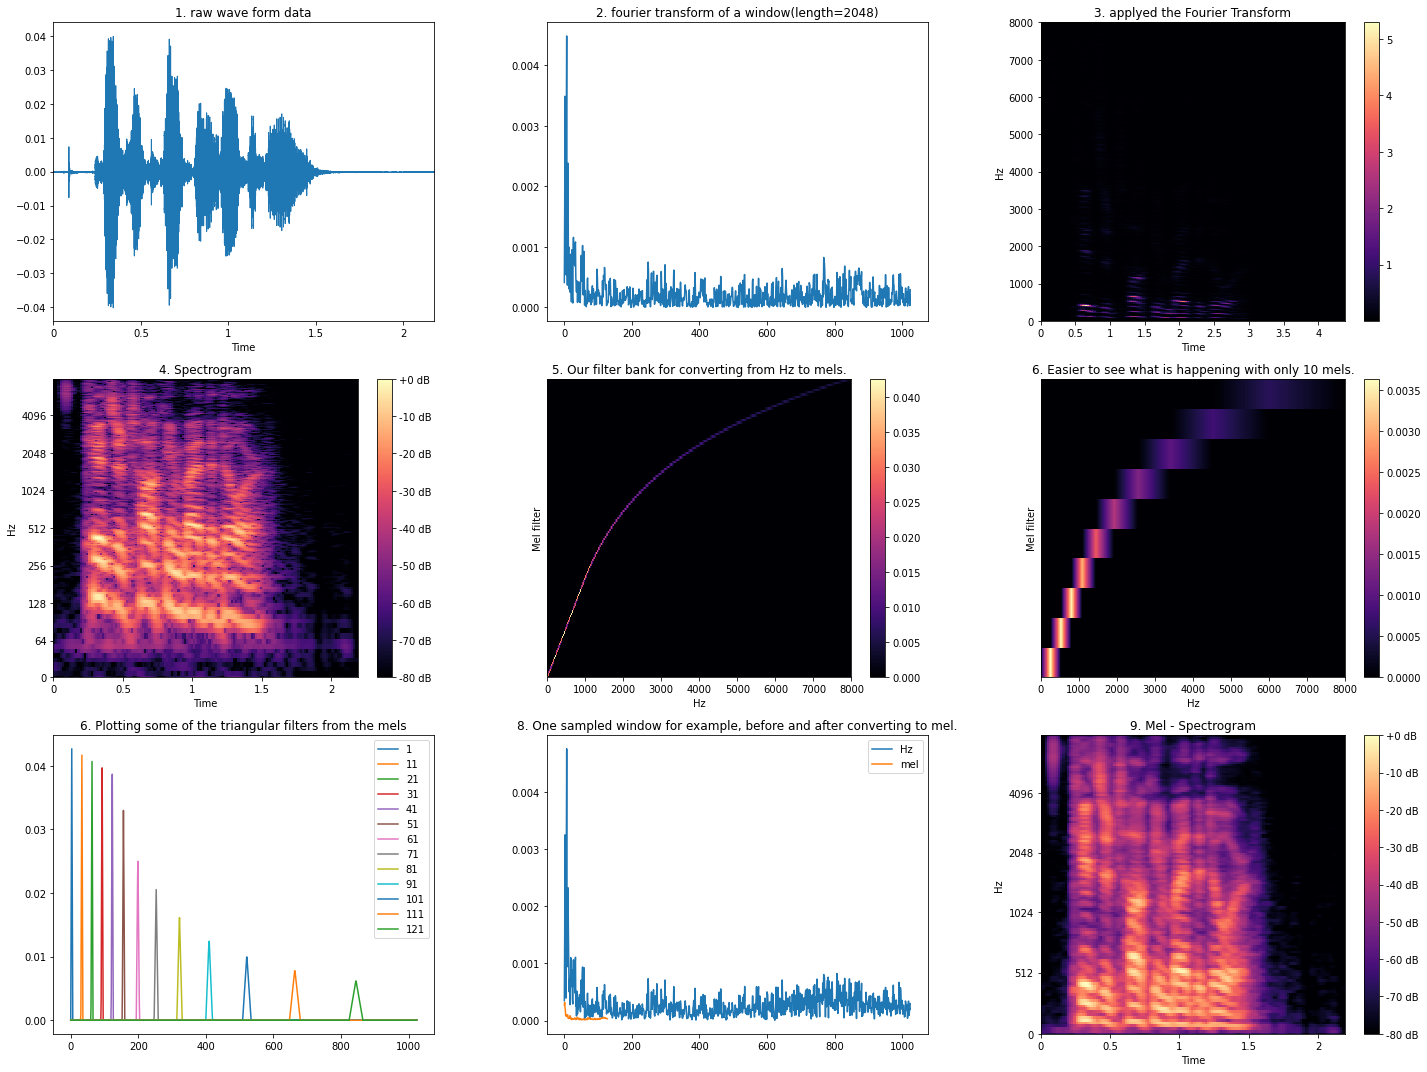

In [ ]:
path = "/content/train/Actor_01/03-01-01-01-01-01-01.wav"
show_audio(path)

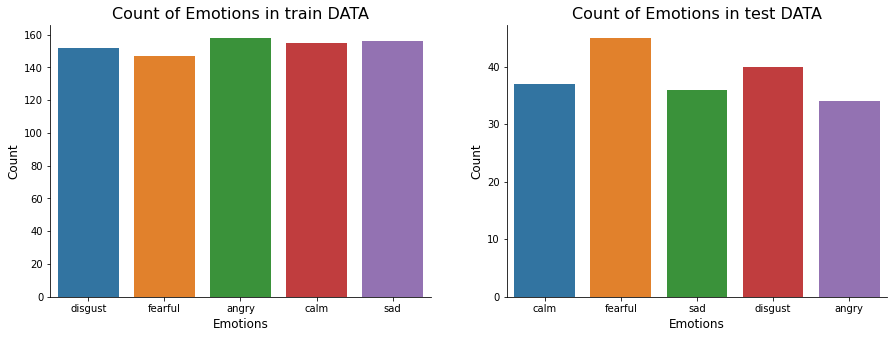

In [ ]:
# Emotions Distribution
fig = plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.title('Count of Emotions in train DATA', size=16)
sns.countplot(x=y_train)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
# plt.show()

plt.subplot(1,2,2)
plt.title('Count of Emotions in test DATA', size=16)
sns.countplot(x=y_test)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

**4. Model Training**


In [ ]:
# clone package repository and creating package 'dbn'
!git clone https://github.com/albertbup/deep-belief-network
%cd deep-belief-network
!git pull origin master
!pip install -r requirements.txt
!python setup.py install

Cloning into 'deep-belief-network'...
remote: Enumerating objects: 795, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 795 (delta 13), reused 6 (delta 2), pack-reused 763
Receiving objects: 100% (795/795), 181.30 KiB | 3.63 MiB/s, done.
Resolving deltas: 100% (459/459), done.
/content/deep-belief-network
From https://github.com/albertbup/deep-belief-network
 * branch            master     -> FETCH_HEAD
Already up to date.
     |████████████████████████████████| 17.3 MB 597 kB/s 
     |████████████████████████████████| 14.6 MB 31.5 MB/s 
     |████████████████████████████████| 8.9 MB 35.3 MB/s 
ERROR: Could not find a version that satisfies the requirement tensorflow==1.5.0 (from versions: 1.13.1, 1.13.2, 1.14.0, 1.15.0, 1.15.2, 1.15.3, 1.15.4, 1.15.5, 2.0.0, 2.0.1, 2.0.2, 2.0.3, 2.0.4, 2.1.0, 2.1.1, 2.1.2, 2.1.3, 2.1.4, 2.2.0rc0, 2.2.0rc1, 2.2.0rc2, 2.2.0rc3, 2.2.0rc4, 2.2.0, 2.2.1, 2.2.2, 2.2.3, 2.3.0rc0, 2.3.0rc1, 2.

In [ ]:
from sklearn import svm
from __future__ import print_function

print(__doc__)

import numpy as np

from scipy.ndimage import convolve
from sklearn import linear_model, datasets, metrics
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from dbn.models import UnsupervisedDBN # use "from dbn.tensorflow import SupervisedDBNClassification" for computations on TensorFlow


# Models we will use
clf = svm.SVC(kernel='rbf',decision_function_shape='ovo',C=10e+6,gamma=10e-3)
dbn = UnsupervisedDBN(hidden_layers_structure=[720,720,720],
                      batch_size=128,
                      learning_rate_rbm=0.001,
                      n_epochs_rbm=100,
                      activation_function='sigmoid')

classifier = Pipeline(steps=[('dbn', dbn),
                             ('svm', clf)])

###############################################################################



# Training RBM-Logistic Pipeline
classifier.fit(x_train, y_train)

# ###############################################################################
# # Evaluation

print()
print("DBN using RBM features:\n%s\n" % (
    metrics.classification_report(
        y_test,
        classifier.predict(x_test))))


# ###############################################################################



Automatically created module for IPython interactive environment
[START] Pre-training step:
>> Epoch 1 finished 	RBM Reconstruction error 27.623204
>> Epoch 2 finished 	RBM Reconstruction error 26.353489
>> Epoch 3 finished 	RBM Reconstruction error 25.513428
>> Epoch 4 finished 	RBM Reconstruction error 25.009296
>> Epoch 5 finished 	RBM Reconstruction error 24.749406
>> Epoch 6 finished 	RBM Reconstruction error 24.668498
>> Epoch 7 finished 	RBM Reconstruction error 24.713986
>> Epoch 8 finished 	RBM Reconstruction error 24.847034
>> Epoch 9 finished 	RBM Reconstruction error 25.043312
>> Epoch 10 finished 	RBM Reconstruction error 25.275688
>> Epoch 11 finished 	RBM Reconstruction error 25.537088
>> Epoch 12 finished 	RBM Reconstruction error 25.810580
>> Epoch 13 finished 	RBM Reconstruction error 26.095398
>> Epoch 14 finished 	RBM Reconstruction error 26.373949
>> Epoch 15 finished 	RBM Reconstruction error 26.649774
>> Epoch 16 finished 	RBM Reconstruction error 26.921222
>> Ep

In [ ]:
y_pred = classifier.predict(x_test)

In [ ]:
###############################################################################
# Evaluation

print()
print("DBN using RBM features:\n%s\n" % (
    metrics.classification_report(
        y_test,
        classifier.predict(x_test))))


###############################################################################

#DataFlair - Calculate the accuracy of our model
accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)

#DataFlair - Print the accuracy
print("Accuracy: {:.2f}%".format(accuracy*100))


DBN using RBM features:
              precision    recall  f1-score   support

       angry       0.70      0.68      0.69        34
        calm       0.82      0.76      0.79        37
     disgust       0.60      0.72      0.66        40
     fearful       0.76      0.71      0.74        45
         sad       0.69      0.67      0.68        36

    accuracy                           0.71       192
   macro avg       0.71      0.71      0.71       192
weighted avg       0.72      0.71      0.71       192


Accuracy: 70.83%


1. Hidden Layers: [360,720,720,360]

     Epoch: 100

     Accuracy: 65.10

     n_mfcc: 40

     emotions: 5
  


2.   Hidden Layers: [360,720,360]

     Epoch: 100

     Accuracy: 71.88

     n_mfcc: 40

     emotions: 5

3. Hidden Layers: [360,720,720,720,360]

     Epoch: 50

     Accuracy: 46.67
   
4.   Hidden Layers: [360,720,720,360] K

     Epoch: 150

     Accuracy: 49.17%

5.   Hidden Layers: [360,720,720,720,360] R

     Epoch: 100

     Accuracy: 42.22%

6.   Hidden Layers: [360,720,720,360] k

     Epoch: 200

     Accuracy: 37.78%
    

7.  Hidden Layers: [360,720,720,720,360] R

     Epoch: 150

     Accuracy: 38.33%

8.  Hidden Layers: [360,720,720,720,360] R

     Epoch: 200

     Accuracy: 30.28%

9.  Hidden Layers: [720,720,720,720,720] R

     Epoch: 100

     Accuracy: 46.39%

10. Hidden Layers: [720,720,720,720] k

     Epoch: 100

     Accuracy: 48.33%

11. Hidden Layers: [180,360,720,720,360,180] k

     Epoch: 50

     Accuracy:35.83%
     





In [ ]:
from sklearn import svm
from __future__ import print_function

print(__doc__)

import numpy as np

from scipy.ndimage import convolve
from sklearn import linear_model, datasets, metrics
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from dbn.models import UnsupervisedDBN # use "from dbn.tensorflow import SupervisedDBNClassification" for computations on TensorFlow
from sklearn.neural_network import BernoulliRBM
from sklearn.base import clone

# Models we will use
clf = svm.SVC(kernel='rbf',decision_function_shape='ovo',C=10e+6,gamma=10e-3)
brbm1 = BernoulliRBM(n_components=1440,learning_rate=0.001,batch_size=64,n_iter=100)


classifier3 = Pipeline(steps=[('brbm1', brbm1),
                             ('svm', clf)])


###############################################################################

# brbm.fit(x_train)


# Training RBM-Logistic Pipeline
classifier3.fit(x_train, y_train)



###############################################################################
# Evaluation

print()
print("BRBM using RBM features:\n%s\n" % (
    metrics.classification_report(
        y_test,
        classifier3.predict(x_test))))


###############################################################################

Automatically created module for IPython interactive environment

BRBM using RBM features:
              precision    recall  f1-score   support

       angry       0.70      0.76      0.73        34
        calm       0.77      0.81      0.79        37
     disgust       0.72      0.78      0.75        40
     fearful       0.75      0.73      0.74        45
         sad       0.69      0.56      0.62        36

    accuracy                           0.73       192
   macro avg       0.73      0.73      0.73       192
weighted avg       0.73      0.73      0.73       192




In [ ]:
y_pred3 = classifier3.predict(x_test)

# y_pred2 = classifier2.predict(x_test)
#DataFlair - Calculate the accuracy of our model
accuracy3=accuracy_score(y_true=y_test, y_pred=y_pred3)

#DataFlair - Print the accuracy
print("Accuracy: {:.2f}%".format(accuracy3*100))

Accuracy: 72.92%


In [ ]:
from sklearn import svm
from __future__ import print_function

print(__doc__)

import numpy as np

from scipy.ndimage import convolve
from sklearn import linear_model, datasets, metrics
# from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from dbn.models import SupervisedDBNClassification # use "from dbn.tensorflow import SupervisedDBNClassification" for computations on TensorFlow


# Models we will use

supervised_dbn = SupervisedDBNClassification(hidden_layers_structure=[360,720,720,360],
                                         learning_rate_rbm=0.001,
                                         learning_rate=0.1,
                                         n_epochs_rbm=50,
                                         n_iter_backprop=50,
                                         batch_size=256,
                                         activation_function='sigmoid',
                                         dropout_p=0.2)

s_clf = svm.SVC(kernel='rbf',decision_function_shape='ovo',C=10e+6,gamma=10e-3)
# dbn = UnsupervisedDBN(hidden_layers_structure=[512,512,512,256],
#                       batch_size=256,
#                       learning_rate_rbm=0.01,
#                       n_epochs_rbm=50,
#                       activation_function='sigmoid')

# classifier2 = Pipeline(steps=[('dbn', supervised_dbn),
#                              ('svm', s_clf)])

###############################################################################



# Training RBM-Logistic Pipeline
# classifier2.fit(x_train, y_train)
supervised_dbn.fit(x_train, y_train)



###############################################################################
# Evaluation

print()
print("DBN using RBM features:\n%s\n" % (
    metrics.classification_report(
        y_test,
        # classifier2.predict(x_test))))
        supervised_dbn.predict(x_test))))


###############################################################################

Automatically created module for IPython interactive environment
[START] Pre-training step:
>> Epoch 1 finished 	RBM Reconstruction error 9.095421
>> Epoch 2 finished 	RBM Reconstruction error 8.994233
>> Epoch 3 finished 	RBM Reconstruction error 8.897617
>> Epoch 4 finished 	RBM Reconstruction error 8.805734
>> Epoch 5 finished 	RBM Reconstruction error 8.718628
>> Epoch 6 finished 	RBM Reconstruction error 8.635951
>> Epoch 7 finished 	RBM Reconstruction error 8.557703
>> Epoch 8 finished 	RBM Reconstruction error 8.484937
>> Epoch 9 finished 	RBM Reconstruction error 8.416026
>> Epoch 10 finished 	RBM Reconstruction error 8.351317
>> Epoch 11 finished 	RBM Reconstruction error 8.290276
>> Epoch 12 finished 	RBM Reconstruction error 8.233429
>> Epoch 13 finished 	RBM Reconstruction error 8.180604
>> Epoch 14 finished 	RBM Reconstruction error 8.131481
>> Epoch 15 finished 	RBM Reconstruction error 8.086493
>> Epoch 16 finished 	RBM Reconstruction error 8.044956
>> Epoch 17 finished 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
y_pred2 = supervised_dbn.predict(x_test)

# y_pred2 = classifier2.predict(x_test)
#DataFlair - Calculate the accuracy of our model
accuracy2=accuracy_score(y_true=y_test, y_pred=y_pred2)

#DataFlair - Print the accuracy
print("Accuracy: {:.2f}%".format(accuracy2*100))

Accuracy: 29.17%


In [ ]:
#importing meow rbm
%cd /content
!git clone https://github.com/meownoid/tensorflow-rbm
%cd tensorflow-rbm
!git pull origin master
!pip install -r requirements.txt
!python setup.py install

/content
Cloning into 'tensorflow-rbm'...
remote: Enumerating objects: 428, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 428 (delta 6), reused 20 (delta 5), pack-reused 403
Receiving objects: 100% (428/428), 1.01 MiB | 1.79 MiB/s, done.
Resolving deltas: 100% (248/248), done.
/content/tensorflow-rbm
From https://github.com/meownoid/tensorflow-rbm
 * branch            master     -> FETCH_HEAD
Already up to date.
running install
running build
running build_py
creating build
creating build/lib
creating build/lib/tfrbm
copying tfrbm/rbm.py -> build/lib/tfrbm
copying tfrbm/bbrbm.py -> build/lib/tfrbm
copying tfrbm/util.py -> build/lib/tfrbm
copying tfrbm/__init__.py -> build/lib/tfrbm
copying tfrbm/gbrbm.py -> build/lib/tfrbm
running install_lib
creating /usr/local/lib/python3.7/dist-packages/tfrbm
copying build/lib/tfrbm/rbm.py -> /usr/local/lib/python3.7/dist-packages/tfrbm
copying build/lib/tfrbm/bbrbm.py -> /usr/local

In [ ]:
from sklearn import svm
from __future__ import print_function

print(__doc__)

import numpy as np

from scipy.ndimage import convolve
from sklearn import linear_model, datasets, metrics
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from dbn.models import UnsupervisedDBN # use "from dbn.tensorflow import SupervisedDBNClassification" for computations on TensorFlow
from sklearn.neural_network import BernoulliRBM

# Models we will use
clf = svm.SVC(kernel='rbf',decision_function_shape='ovo',C=10e+6,gamma=10e-3)
# dbn = UnsupervisedDBN(hidden_layers_structure=[360,720,720,360],
#                       batch_size=256,
#                       learning_rate_rbm=0.001,
#                       n_epochs_rbm=150,
#                       activation_function='sigmoid')

# brbm1 = BernoulliRBM(n_components=360,learning_rate=0.001,batch_size=256,n_iter=100)

rbm = GBRBM(n_visible =360, n_hidden = 720, learning_rate=0.01, sigma=1.0)
rbm.fit(x_train,epoches =50,batch_size =256)
# classifier3 = Pipeline(steps=[('rbm', rbm),
#                              ('svm', clf)])


###############################################################################

# brbm.fit(x_train)


# Training RBM-Logistic Pipeline
# classifier3.fit(x_train, y_train)



###############################################################################
# Evaluation

print()
print("DBN using RBM features:\n%s\n" % (
    metrics.classification_report(
        y_test,
        rbm.predict(x_test))))


###############################################################################

Automatically created module for IPython interactive environment


AttributeError: ignored

In [ ]:
import tensorflow as tf
from tfrbm import BBRBM,GBRBM

In [ ]:
from PIL import Image
from sklearn import svm
from __future__ import print_function

print(__doc__)

import numpy as np

from scipy.ndimage import convolve
from sklearn import linear_model, datasets, metrics
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from dbn.models import UnsupervisedDBN

# Models we will use
clf = svm.SVC(kernel='rbf',decision_function_shape='ovo',C=10e+6,gamma=10e-3)
# dbn = UnsupervisedDBN(hidden_layers_structure=[360,720,720,360],
#                       batch_size=256,
#                       learning_rate_rbm=0.001,
#                       n_epochs_rbm=150,
#                       activation_function='sigmoid')

brbm = BBRBM(n_visible=40,n_hidden=256,learning_rate=0.001)
dataset = tf.data.Dataset.from_tensor_slices(x_train.reshape(-1,40).astype(np.float32))
dataset = dataset.shuffle(768, reshuffle_each_iteration=True)
brbm.fit(dataset,epoches=50, batch_size=256)

#classifier3 = Pipeline(steps=[('rbm', brbm)])
#                              ('svm', clf)])

###############################################################################

# brbm.fit(x_train)


# Training RBM-Logistic Pipeline
#classifier3.fit(dataset,50)



###############################################################################
# Evaluation

#print()
#print("DBN using RBM features:\n%s\n" % (
#    metrics.classification_report(
#        y_test,
#        classifier3.reconstruct(dataset))))

#for i in np.random.choice(np.arange(x_test.shape[0]), 5, replace=False):
#        x = x_test[i]
#        x_tensor = tf.convert_to_tensor(x.reshape(-1, 40), dtype=tf.float32)
#        x_reconstructed_tensor = rbm.reconstruct(x_tensor)
#        x_reconstructed = x_reconstructed_tensor.numpy().reshape(-1, 40)
#        print(x_reconstructed)

      



###############################################################################

Automatically created module for IPython interactive environment


[1.1864742040634155,
 1.1159101724624634,
 1.1084588766098022,
 1.1173770427703857,
 1.1468784809112549,
 1.0896413326263428,
 1.101787805557251,
 1.0812082290649414,
 1.0619691610336304,
 1.0118176937103271,
 1.0348199605941772,
 1.0660464763641357,
 1.0632911920547485,
 0.9889240264892578,
 0.9396136403083801,
 0.9348155856132507,
 0.9822646379470825,
 0.9582306146621704,
 0.9136859178543091,
 0.9354696273803711,
 0.9425519704818726,
 0.9361665844917297,
 0.8995628356933594,
 0.9073885679244995,
 0.8905765414237976,
 0.8966425657272339,
 0.942196249961853,
 0.8990030288696289,
 0.9202858209609985,
 0.9098436236381531,
 0.9246231913566589,
 0.9067193865776062,
 0.9078399538993835,
 0.9374098777770996,
 0.9147550463676453,
 0.9029695391654968,
 0.8743330836296082,
 0.9722545742988586,
 0.9281541705131531,
 0.9147591590881348,
 0.9083436727523804,
 0.9646650552749634,
 0.9622829556465149,
 0.9183737635612488,
 0.9207617044448853,
 0.934054970741272,
 0.9602754712104797,
 0.9202368855476

In [ ]:
for i in np.random.choice(np.arange(x_test.shape[0]), 5, replace=False):
        x = x_test[i]
        x_tensor = tf.convert_to_tensor(x.reshape(-1,40), dtype=tf.float32)
        x_reconstructed_tensor = rbm.reconstruct(x_tensor)
        x_reconstructed = x_reconstructed_tensor.numpy().reshape(-1,40)
        Image.fromarray((x_reconstructed * 255).astype(np.uint8)).save(f'{i}_reconstructed.png')

In [ ]:
y_pred3 = brbm.predict(x_test)

# y_pred2 = classifier2.predict(x_test)
#DataFlair - Calculate the accuracy of our model
accuracy3=accuracy_score(y_true=y_test, y_pred=y_pred3)

#DataFlair - Print the accuracy
print("Accuracy: {:.2f}%".format(accuracy3*100))

AttributeError: ignored